In [1]:
cd /Users/cl1704/PycharmProjects/clustering_in_rnns

/Users/cl1704/PycharmProjects/clustering_in_rnns


In [2]:



def compute_var(variance, n):
    return np.sum(variance[n:])


def compute_p(k, null_k):
    return (np.sum(null_k < k) / len(null_k))<.05


from Experiment_2.TwoAFCTask import generate_trials
#from Experiment_5.SiegelMillerTask import generate_trials
import networkx as nx
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from Experiment_2.net import *
import os
import statsmodels.api as sm
import scipy.optimize as opt
import math
#from psychometrics import *
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import networkx as nx
from sklearn.cluster import KMeans

plt.rcParams["axes.grid"] = False
from sklearn.manifold import TSNE

matplotlib.rcParams['axes.linewidth'] = .75

/var/folders/9_/yjc4d8zx4tj6kw6h4xgj4zd80000gn/T/ipykernel_96277/1122425788.py:62: RuntimeWarning: overflow encountered in exp
  return  a + b/(1+np.exp(c*(x-d)))


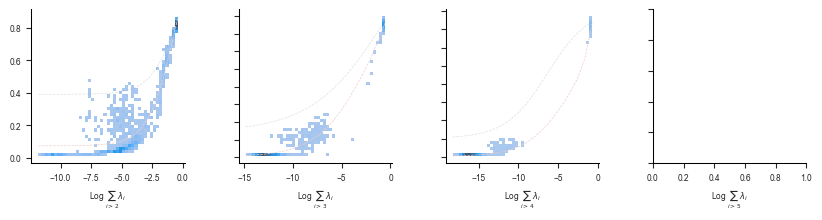

In [3]:
import scipy.optimize as opt
import math
fig = plt.figure(figsize=(10,2))
gs = gridspec.GridSpec(1,4,wspace = .35)
ax0=fig.add_subplot(gs[0,0])
ax1=fig.add_subplot(gs[0,1])
ax2=fig.add_subplot(gs[0,2])
ax3=fig.add_subplot(gs[0,3])
axes = [ax0,ax1,ax2,ax3]

df_list = []
for filename in os.listdir('Experiment_2/Results_2'):
    f = os.path.join('Experiment_2/Results_2', filename)
    if os.path.isfile(f):
        df_list.append(pd.read_pickle(f))
original_df_act = pd.concat(df_list,ignore_index=True) 
original_df_act = original_df_act[original_df_act.mse_z<.04]
#original_df_act = original_df_act[original_df_act.lambda_std==0.1]
#original_df_act = original_df_act[original_df_act.sigma_rec==0.2]
original_df_act = original_df_act[original_df_act.n==100]
original_df_act.weight_decay = original_df_act.weight_decay.astype(float)
#original_df_act = original_df_act[original_df_act.weight_decay==0.0]
#original_df_act = original_df_act[original_df_act.activity_std<.01]
#original_df_act = original_df_act[original_df_act.beta==5.]


#original_df = original_df[original_df.k>1]
parameters = []
fit_rows = []

for i in range(3):
    ax = axes[i]
    k = i+2
    df = original_df_act.copy()
    df['var'] = df.variance.apply(lambda x: compute_var(x,k))
    df['k_inertia'] = df.inertia.apply(lambda x: x[k-1])
    df['var'] = np.log(df['var'])
    #df = df[df.k>=k]
    df = df[df.dim==k]
    #print(df.lvar.min())
    #df = df[df['var']<-.35]
    
        # Construct null dataframe
    rows = []
    for index, row in df.iterrows():
        null = row['null_inertia']
        for run in range(null.shape[1]):
            rows.append({'model_id':row['model_id'],
                         'var':row['var'],
                         'sigma_rec': row['sigma_rec'],
            'run':run,
            'inertia': null[k-1,run]})
    null_df = pd.DataFrame(rows)     
   # null_df = null_df.groupby(['model_id']).mean().reset_index()
    sns.histplot(data=df, x='var',y='k_inertia',ax=ax,legend=False,alpha=1,bins=(45,45))
    # sns.histplot(data=null_df, x='var',y='inertia',ax=ax,legend=False,alpha=1,bins=(45,45),color='gray')


    def f(x, a,b,c,d):
        #return a + c * np.log(1 + np.exp(b * (x-d))) / b
        #return a + c*np.log(1+np.exp(20 * (x-b)))/20
        return  a + b/(1+np.exp(c*(x-d)))
    # bounds = ([0,0,-np.inf,-np.inf],
    #               [np.inf, np.inf,0,0])
    bounds = ([0,0,-np.inf,-np.inf],
                  [np.inf, np.inf,0,0])
    x_values = np.linspace(df['var'].min(),df['var'].max(),20)
    for sigma_rec in [0., 0.5]:
        for sample in range(100):   
            #try:
            frac = .1
            sample_df = df[df.sigma_rec == sigma_rec].sample(frac=frac)
            x = sample_df['var'].values.astype(float)
            y = sample_df.k_inertia.values
    
            sample_null_df = null_df[null_df.sigma_rec==sigma_rec].sample(frac=frac)
            x_null = sample_null_df['var'].values.astype(float)
            y_null = sample_null_df.inertia.values
    
            try:
                popt, pcov = opt.curve_fit(f, x, y, method="trf",max_nfev=10000,bounds = bounds)
                #popt, pcov = opt.curve_fit(f, x, y, method="trf",max_nfev=10000)
                y_fit = f(x_values, *popt)
    
                for step in range(20):
                    fit_rows.append({'sample':sample,
                                     'step': step,
                                     'k':k,
                                     'sigma_rec':sigma_rec,
                                 'type': 1,
                                 'x':x_values[step],
                                 'y': y_fit[step],
                                 'a':popt[0]})
            except:
                continue
        

        try:
            popt, pcov = opt.curve_fit(f, x_null, y_null, method="trf",max_nfev=10000,bounds = bounds)
            y_fit = f(x_values, *popt)
            for step in range(20):
                fit_rows.append({'sample':sample,
                                 'step':step,
                                 'k':k,
                                 'sigma_rec':sigma_rec,
                             'type': 0,
                             'x':x_values[step],
                             'y': y_fit[step],
                             'a':popt[0]})
        except:
           continue
  


fit_df = pd.DataFrame(fit_rows)
for k in range(3):
    ax = axes[k]
    sns.lineplot(data = fit_df[(fit_df.type==1) & (fit_df.k==k+2)], x= 'x', y='y',ax=ax,legend = False,lw=.5,color='tab:blue',alpha = 1,errorbar=None, linestyle='--',hue = 'sigma_rec')
    sns.lineplot(data = fit_df[(fit_df.type==0)& (fit_df.k==k+2)], x= 'x', y='y',ax=ax,legend = False,lw=.5,color='gray',linestyle='--',alpha= .25, errorbar = None)

for ax in [ax0,ax1,ax2,ax3]:
#     
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel('', fontsize=8)
    ax.xaxis.set_tick_params(labelsize=6,bottom=True)
    ax.yaxis.set_tick_params(labelsize=6,left=True)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
   # plt.yticks(list(plt.yticks()[0]) + [5.0])
    #ax.set_ylim(-.01,1)
    #ax.set_xlim(-10,-2)
ax1.set_yticklabels([])
ax2.set_yticklabels([])
ax3.set_yticklabels([])


ax0.set_xlabel("Log " + r"$\sum_{i>2}\lambda_i$", fontsize=6)
ax1.set_xlabel("Log " +r"$\sum_{i>3}\lambda_i$", fontsize=6)
ax2.set_xlabel("Log " +r"$\sum_{i>4}\lambda_i$", fontsize=6)
ax3.set_xlabel("Log " +r"$\sum_{i>5}\lambda_i$", fontsize=6)
fig.savefig('/Users/cl1704/PycharmProjects/Clustering/Figures/MainFig_1_a.jpg',
    format='jpeg',
    dpi=450,
    bbox_inches='tight'

            )

In [9]:


df_list = []
for filename in os.listdir('Experiment_2/Results_2'):
    f = os.path.join('Experiment_2/Results_2', filename)
    if os.path.isfile(f):
        df_list.append(pd.read_pickle(f))
original_df = pd.concat(df_list,ignore_index=True) 
original_df = original_df[original_df.mse_z<.045]
df = original_df.copy()

# Restrict to networks with dim and compute variance above dim
dim = 2
df = df[df.dim == dim]
df = df[df.k >= dim]
df['var'] = df.variance.apply(lambda x: compute_var(x, dim))
df['k_inertia'] = df.inertia.apply(lambda x: x[dim - 1])
df['var'] = np.log(df['var'])
df.sort_values('var', ascending=True)




,model_id,w_rec,w_in,w_out,bias,mse_z,weight_decay,threshold,sigma_rec,lambda_std,...,lvar,dim,k,p_value,inertia,activity_std,null_inertia,variance,var,k_inertia
4819,WFS60cLB,"[[0.0003641479, -0.006470179, 0.032763887, 0.0...","[[0.46857515], [-0.6884165], [-0.08386951], [-...","[[-0.090412945, -0.030083587, -0.025426403, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.037341,0.001,0.05,0.5,0.1,...,1.000000,2,2,0.0,"[0.9995362268518518, 0.014095157877604167, 0.0...",0.025344882,"[[0.999147936785175, 0.9942583174975171, 0.999...","[0.9860577, 0.013934988, 6.6121183e-06, 7.3771...",-11.815928,0.014095
4803,uNdsTMDE,"[[0.00461943, 0.01239753, 0.013592523, -0.0164...","[[0.07926836], [0.06401878], [0.061689258], [-...","[[0.007975028, 0.0042787776, 0.004250164, 0.00...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.033449,0.001,0.05,0.5,0.1,...,1.000000,2,2,0.0,"[0.9998386574260814, 0.015417842182541414, 0.0...",0.009727193,"[[0.994077807552882, 0.9998681977536373, 0.967...","[0.9846036, 0.015385534, 1.0434558e-05, 3.9609...",-11.432102,0.015418
4815,EWkC06Bj,"[[-0.0055821813, 0.025438417, 0.003118132, -0....","[[-0.2346163], [0.051668376], [-0.041389316], ...","[[0.06917878, 0.005824518, -0.014432485, -0.00...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.039890,0.001,0.05,0.5,0.1,...,1.000000,2,2,0.0,"[0.9977598382222409, 0.014928464164818963, 0.0...",0.015838763,"[[0.9622506866229703, 0.9980466180731016, 0.98...","[0.98475945, 0.015229413, 1.0406331e-05, 6.101...",-11.412319,0.014928
4798,gqBx5n8L,"[[0.011480065, -0.018827423, -0.0052113966, 0....","[[-0.23567848], [0.5310393], [0.101006], [-0.0...","[[0.010496213, 0.024883151, -0.004542362, -0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.032484,0.001,0.05,0.5,0.1,...,1.000000,2,2,0.0,"[0.9983783566691716, 0.014637046193628912, 0.0...",0.018849015,"[[0.968141959885208, 0.9781681191334697, 0.985...","[0.9855616, 0.014426855, 1.10797755e-05, 5.094...",-11.362821,0.014637
4801,QXGWBgB3,"[[-0.009691865, -0.036993664, 0.0007140425, -0...","[[-0.078433216], [0.829812], [0.20283833], [0....","[[0.003965315, -0.056600712, -0.054328036, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.034589,0.001,0.05,0.5,0.1,...,1.000000,2,2,0.0,"[0.997828125, 0.01794931098090278, 0.011015681...",0.019844435,"[[0.9355806586562028, 0.998000475766365, 0.995...","[0.9818222, 0.018166201, 1.1357837e-05, 3.1318...",-11.356723,0.017949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1308,jfpKxWia,"[[0.05669519, 0.051966768, -0.11979085, 0.1710...","[[-0.15780443], [-0.13768986], [-0.20756827], ...","[[-0.010182782, 0.010171698, 0.00445559, 0.011...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.032504,0.001,0.05,0.5,0.1,...,-0.421697,2,6,0.0,"[0.9846476851851852, 0.8426949074074074, 0.763...",0.037308328,"[[0.9965782738383618, 0.9852101109328096, 0.99...","[0.19781122, 0.14578205, 0.13130282, 0.1204307...",-0.420975,0.842695
979,aOUMg2O2,"[[0.12141912, -0.037460096, 0.040258933, -0.11...","[[0.59754604], [-0.13885176], [-0.01124915], [...","[[0.023271782, -0.021842008, 0.002648424, 0.02...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.040563,0.001,0.05,0.5,0.1,...,-1.000000,2,6,0.0,"[0.987968287037037, 0.8608556712962963, 0.7767...",0.034910537,"[[0.9894424135054344, 0.9917333417549552, 0.98...","[0.17905314, 0.16305926, 0.12368853, 0.1104382...",-0.418721,0.860856
995,wJNOBVib,"[[0.11435502, 0.095327005, 0.15365586, -0.0738...","[[-0.64397377], [-0.51797855], [-0.5896452], [...","[[0.044601407, 0.02737567, -0.0126274, 0.02756...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.044293,0.001,0.05,0.5,0.1,...,-1.000000,2,6,0.0,"[0.9864375, 0.8622067708333333, 0.785831886574...",0.023010956,"[[0.9875846429040263, 0.9738453399303179, 0.99...","[0.17803365, 0.15883186, 0.13040394, 0.1225196...",-0.410778,0.862207
890,UDv39dbk,"[[0.11422408, -0.12216915, 0.03121821, 0.03075...","[[-0.6461562],

In [10]:
## RESPONSE MATRIX
model_data = df[df.model_id=='WFS60cLB']
net = Net(n=100,input_size = 1,dale=False)
net.recurrent_layer.weight.data = torch.tensor(model_data['w_rec'].item())
net.recurrent_layer.bias.data = torch.tensor(model_data['bias'].item())
net.input_layer.weight.data = torch.tensor(model_data['w_in'].item())
net.output_layer.weight.data = torch.tensor(model_data['w_out'].item())
net.activation = torch.nn.Tanh()
variance = model_data['var'].item()
u, z, mask, conditions  = generate_trials(
                            n_trials=25)
x = net(u).detach().cpu().numpy()

rows = []
for k in range(u.shape[0]):
    rows.append({'trial': k,
                 'motion': conditions[k]['motion_coh'],
                 'response': x[k, :, :]})
df = pd.DataFrame(rows)
df = df.groupby(['motion']).response.apply(lambda r: np.mean(np.stack(r), axis=0)).reset_index()

#df = df.groupby('motion').response.apply(lambda r: np.mean(np.stack(r), axis=0)).reset_index()
responses = np.stack(df.response.values)
responses = responses.reshape(-1, responses.shape[2]).T

#responses = responses[np.mean(responses, axis=1) >.025, :]

# z_score
# responses = (responses - np.mean(responses, axis=1, keepdims=True)) / np.std(responses, axis=1, keepdims=True)
# responses = responses[~np.isnan(responses).any(axis=1)]




In [65]:
#

0.017285459472827842


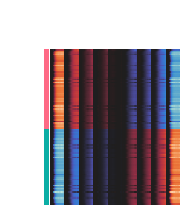

In [11]:
## CLUSTERED RESPONSE MATRIX        
#_,k = compute_k(responses,5,25,.05)
#k = model_data.k.values[0]
k=2
import matplotlib
clustering = KMeans(n_clusters=k, n_init=20).fit(responses)
total_variance = np.sum((responses.T - np.mean(responses.T, axis=0, keepdims=True)) ** 2)
print(clustering.inertia_/total_variance)
labels = clustering.labels_
sort = np.argsort(labels)
sorted_responses = responses[sort, :]
sns.husl_palette(s=.4)
network_pal = sns.husl_palette(pd.Series(np.sort(labels)).unique().size, s=1)
lut = dict(zip(pd.Series(np.sort(labels)).unique(), network_pal))
row_colors = pd.Series(np.sort(labels)).map(lut)
g = sns.clustermap(pd.DataFrame((sorted_responses)), row_cluster=False, col_cluster=False, row_colors=row_colors,
                   figsize=(2, 2.25), cbar_pos=None, xticklabels=False, yticklabels=False, center=0)
ax = g.ax_heatmap

g.savefig('Figures/Fig_2afc_b.jpg',
          format='jpeg',
          dpi=450,
          bbox_inches='tight'
          )

<Axes: ylabel='Count'>

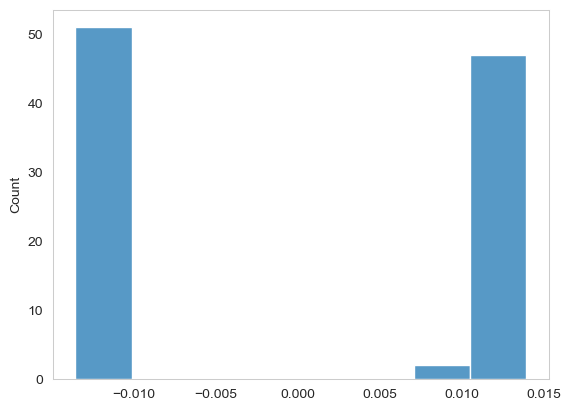

In [12]:
plt.figure()
sns.histplot(x = np.mean(responses,axis=1))

<Axes: >

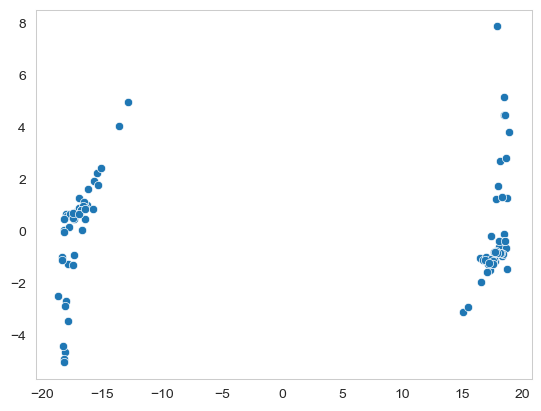

In [13]:
plt.figure()
pca = PCA().fit(responses)
x_proj = pca.transform(responses)
sns.scatterplot(x = x_proj[:,0],y=x_proj[:,1])


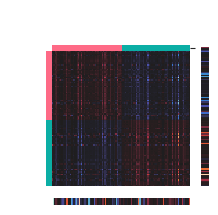

In [14]:

## RECURRENT MATRIX

sort = np.argsort(labels)
w = net.recurrent_layer.weight.data
w_in = net.input_layer.weight.data
w_out = net.output_layer.weight.data

w = w[sort, :]
w = w[:, sort]
w_in = w_in[sort, :]
w_out = w_out[:, sort]

g = sns.clustermap(pd.DataFrame(w), center=0, row_cluster=False, col_cluster=False, row_colors=row_colors,
                   col_colors=row_colors, figsize=(2.25, 2.25), cbar_pos=None, xticklabels=False, yticklabels=False)

g.gs.update(left=0.05, right=0.85, bottom=.15)
gs2 = matplotlib.gridspec.GridSpec(1, 1, left=.9, top=.77, bottom=.15)
ax2 = g.fig.add_subplot(gs2[0])
sns.heatmap(w_in, ax=ax2, cbar=False, xticklabels=False, yticklabels=False, center=0)

gs3 = matplotlib.gridspec.GridSpec(1, 1, left=.24, top=.1, right=.85)
ax3 = g.fig.add_subplot(gs3[0])
sns.heatmap(w_out, ax=ax3, cbar=False, xticklabels=False, yticklabels=False, center=0)

g.savefig('Figures/Fig_2afc_c.jpg',
          format='jpeg',
          dpi=450,
          bbox_inches='tight'
          )

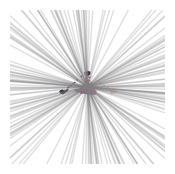

In [52]:
# HYPERPLANES
from sklearn.decomposition import PCA
#import seaborn as sns
from sympy import *
from sympy.plotting import plot
from sympy.plotting import plot_implicit

x = net.forward(u)
n_neurons = x.shape[2]
#Restrict to act

pca = PCA()
pca.fit(x.detach().numpy().reshape(-1,x.shape[2]))

U = pca.components_[:2,:].T
#U = latent_net.module_.q[:2,:].t().detach()
w = net.recurrent_layer.weight.data
#w = w-np.eye(50)
w_in = net.input_layer.weight.data

b = net.recurrent_layer.bias.data
#b = net.input_layer(u[1,60,:]).detach()+0.2

H = w @ U 
#H = H[sort,:]
proj_rates = pca.transform(x.detach().reshape(-1,x.shape[2]))
proj_rates = proj_rates.reshape(-1,75,x.shape[2])

fig = plt.figure(figsize=(2,2))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])

lim =4
xx,yy = np.linspace(-lim,lim), np.linspace(-lim,lim)
x,y = np.meshgrid(xx,yy)
for i in range(n_neurons):
#for i in np.argwhere(labels==0):

    magnitude = np.linalg.norm(H[i,:].numpy())

    #ax.contour(x, y, x*H[i,0].numpy() + y*H[i,1].numpy()+b[i].numpy(), [0],colors=network_pal.as_hex()[labels[i]],linewidths=.75)
    ax.contour(x, y, x*H[i,0].numpy() + y*H[i,1].numpy()+b[i].numpy(), [0],colors='gray',linewidths=1,alpha=.25)

pca = PCA(n_components = 2).fit(responses.T)
pcs = torch.tensor(pca.components_).float()
n_steps = 25
matrix = np.zeros((n_steps,n_steps))
xs = []
ys = []
lim = 1*np.max(proj_rates)
for i in range(n_steps):
    for j in range(n_steps):
        xs.append(np.linspace(-lim,lim,n_steps)[i])
        ys.append(np.linspace(-lim,lim,n_steps)[j])
        
        # Inverse transform (x,y) into state space
        #z = torch.tensor(pca.inverse_transform(np.array([[x,y]]))).float()
#sns.scatterplot(x = xs,y =ys,ax=ax,s=1)
#for i in range(n_neurons):
# for i in np.argwhere(labels==0):
# 
#     magnitude = np.linalg.norm(H[i,:].numpy())
# 
#     #ax.contour(x, y, x*H[i,0].numpy() + y*H[i,1].numpy()+b[i].numpy(), [0],colors=network_pal.as_hex()[labels[i]],linewidths=.75)
#     ax.contour(x, y, x*H[i,0].numpy() + y*H[i,1].numpy()+b[i].numpy(), [0],color='gray',linewidths=.75,alpha=1)


# for i in np.argwhere(labels==1):
# 
#     magnitude = np.linalg.norm(H[i,:].numpy())
# 
#     #ax.contour(x, y, x*H[i,0].numpy() + y*H[i,1].numpy()+b[i].numpy(), [0],colors=network_pal.as_hex()[labels[i]],linewidths=.75)
#     ax.contour(x, y, x*H[i,0].numpy() + y*H[i,1].numpy()+b[i].numpy(), [0],color='gray',linewidths=.75)


# for i in range(25):
#     ax.plot(proj_rates[i,:,0],proj_rates[i,:,1],lw=1)
x = net.forward(u).detach().cpu().numpy()
pca = PCA()
pca.fit(x.reshape(-1, x.shape[2]))
x_proj = pca.transform(x.reshape(-1, x.shape[2])).reshape(x.shape[0], x.shape[1], x.shape[2])
rows = []
for k in range(u.shape[0]):
    for t in range(u.shape[1]):
        rows.append({'trial': k,
                     'motion': conditions[k]['motion_coh'],
                     't': t,
                     'z_1': x_proj[k, t, 0],
                     'z_2': x_proj[k, t, 1], })
new_df = pd.DataFrame(rows)
new_df_mean = new_df.groupby(['motion', 't']).mean().reset_index()


sns.scatterplot(data=new_df_mean,x='z_1',y='z_2',hue='motion',ax=ax,legend=False,s=1,alpha=1,edgecolor=None)
    
# sns.scatterplot(data=new_df_mean, x='z_1', y='z_2', ax=ax, legend=False, s=3, alpha=.5, hue='t',
#                 palette=palette)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_yticks([])
ax.set_xticks([])
# ax.set_xlim(-4.2,4.2)
# ax.set_ylim(-4.2,4.2)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.savefig('Figures/Fig1c.jpg',
            format='jpeg',
            dpi=450,
            bbox_inches='tight'
            )

In [3]:
device='cpu'
u, z, mask, conditions = generate_trials(n_trials=25)
net = Net(n=100, 
          input_size=u.shape[2], 
          dale=False, 
          sigma_in=0.1,
          sigma_rec=.5,
          lambda_std=.1,
          mag = .5,
          activation = torch.nn.Tanh()).to(device)

# Fit with penalty
net.fit(u.to(device=device), z.to(device=device), mask.to(device=device), lr=.005,
        epochs=1000,
        conditions=conditions,
        verbose=True,
        lvar=0,
        dim=2,
        weight_decay=0)


Epoch: 50/1000............. mse_z: 0.0407
Epoch: 100/1000............. mse_z: 0.0414
Epoch: 150/1000............. mse_z: 0.0403
Epoch: 200/1000............. mse_z: 0.0402
Epoch: 250/1000............. mse_z: 0.0411
Epoch: 300/1000............. mse_z: 0.0397
Epoch: 350/1000............. mse_z: 0.0406
Epoch: 400/1000............. mse_z: 0.0408
Epoch: 450/1000............. mse_z: 0.0416
Epoch: 500/1000............. mse_z: 0.0405
Epoch: 550/1000............. mse_z: 0.0411
Epoch: 600/1000............. mse_z: 0.0411
Epoch: 650/1000............. mse_z: 0.0404
Epoch: 700/1000............. mse_z: 0.0405
Epoch: 750/1000............. mse_z: 0.0400
Epoch: 800/1000............. mse_z: 0.0402
Epoch: 850/1000............. mse_z: 0.0421
Epoch: 900/1000............. mse_z: 0.0412
Epoch: 950/1000............. mse_z: 0.0406
Epoch: 1000/1000............. mse_z: 0.0411
